In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from PIL import Image
import os



In [3]:
#Prepare images

#Change to the location of your images
path = "YOURPATH/TrainingSet/TrainingSet/Closed"
dirs = os.listdir( path )

filenamesO = []
filenamesC = []

def load_images_from_folder(folder, closedB):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            if closedB == True:
                filenamesC.append(filename)
            else:
                filenamesO.append(filename)
    return images


# Load images from folders A and B
#Basically creating two list, A Closed, B Opened
images_A = load_images_from_folder('YOURPATH/TrainingSet/TrainingSet/Closed', True)  # replace with actual path
images_B = load_images_from_folder('YOURPATH/TrainingSet/TrainingSet/Opened', False)  # replace with actual path

#Make the images the same size
def preprocess_images(images, dimensions=(64, 64)):
    return [img.resize(dimensions) for img in images]

images_A = preprocess_images(images_A)
images_B = preprocess_images(images_B)


#Create list of closed and opened eyes

opened_eyes = []
closed_eyes = []
count = 0


print (filenamesC)
print (filenamesO)
print ('Closed size:' + str(len(filenamesC)))
print ('Opened size:' + str(len(filenamesO)))
#Shows balanced dataset

Closed size:880
Opened size:824


In [5]:
#Data prep

import pandas as pd
import json
import ast

# Initialize an empty list to store iris sizes
features = []

for file in os.listdir('YOURPATH/sleep/TrainingSet_json/TrainingSet_json'):
    if file.endswith('.json'):

        #Create an entry for the features dictionary
        entry = {'FileName': file, 'Iris_Size': 0.0, 'Pupil_Size': 0.0, 'Look_Vec' : (0.0,0.0,0.0), 'Closed': file in filenamesC}

        full_path = os.path.join('YOURPATH', file)

        try:
            # Open and read the file
            with open(full_path, 'r') as f:
                data = json.load(f)

            # Extract the iris_size and add it to the list
            iris_size = data.get('eye_details', {}).get('iris_size', None)
            pupil_size = data.get('eye_details', {}).get('pupil_size', None)
            look_vec = data.get('eye_details', {}).get('look_vec', None)

            #print (Look_Vec)
            #Add the iris_size to the list
            entry['Iris_Size'] = float(iris_size)
            entry['Pupil_Size'] = float(pupil_size)
            lvt = ast.literal_eval(look_vec)
            entry['Look_Vec'] = lvt

            #remove extension for comparing between image and json files
            file = file.split(".")[0]
            updatedFileNamesC = []

            for i in range(len(filenamesC)):
                if filenamesC[i].split(".")[0] == file:
                  #Again, stripping off extensions for comparing
                  updatedFileNamesC.append(filenamesC[i].split(".")[0])

            if file in updatedFileNamesC:
                entry['Closed'] = True
            else:
                entry['Closed'] = False

        except json.JSONDecodeError:
            print(f"Error decoding JSON in file: {file}")
        except FileNotFoundError:
            print(f"File not found: {file}")
        except Exception as e:
            print(f"An error occurred with file {file}: {e}")

        #Add Entry to list
        features.append(entry)




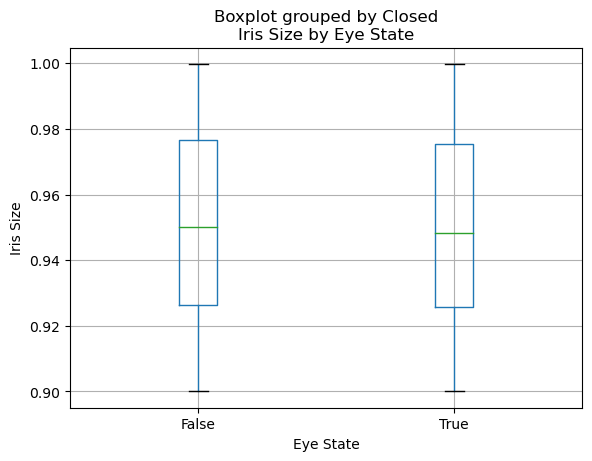

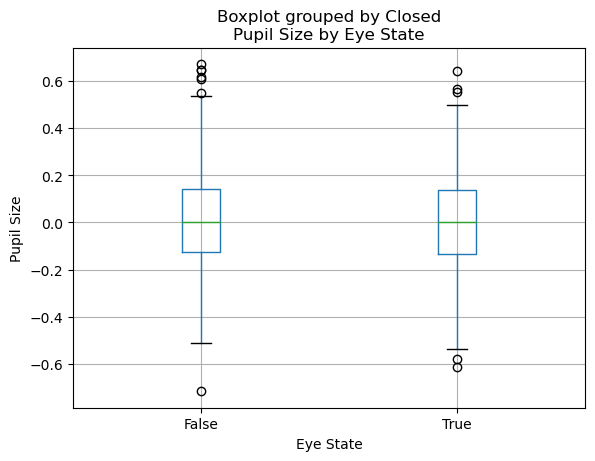

In [7]:
#Visualizing the dataset a bit

import matplotlib.pyplot as plt

df = pd.DataFrame(features)

# Plotting
# Box plot
df.boxplot(column='Iris_Size', by='Closed')

plt.title('Iris Size by Eye State')
plt.xlabel('Eye State')
plt.ylabel('Iris Size')
plt.show()


df.boxplot(column='Pupil_Size', by='Closed')
plt.title('Pupil Size by Eye State')
plt.xlabel('Eye State')
plt.ylabel('Pupil Size')
plt.show()




#Remember, False indicates the eyes are NOT closed

Precision : 0.8157894736842105
Recall : 0.8908045977011494


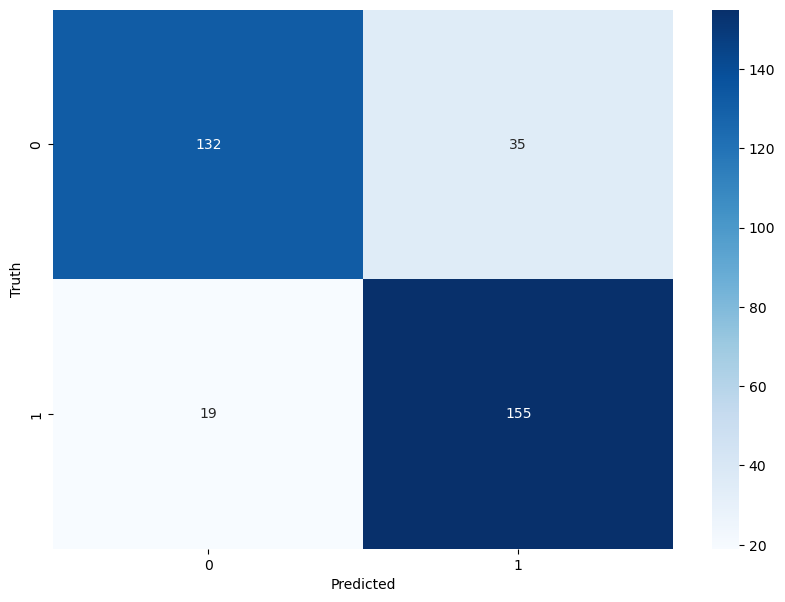

In [8]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import ast

#Some feature engineering
df['P-I'] = df['Iris_Size'] / df['Pupil_Size']

df['LVX'] = df['Look_Vec'].apply(lambda x: float(x[0]))
df['LVY'] = df['Look_Vec'].apply(lambda x: float(x[1]))
df['LVZ'] = df['Look_Vec'].apply(lambda x: float(x[2]))

#increase max iterations to help with model convergence
clf = LogisticRegression(max_iter=500)

#Splitting the dataset into training and testing sets, use random state for testing
x_train, x_test, y_train, y_test = train_test_split(df[['Iris_Size', 'Pupil_Size', 'P-I', 'LVX', 'LVY', 'LVZ']], df['Closed'], test_size=0.2, random_state=42)

#Fit
clf.fit(x_train, y_train)

#Predict
y_pred = clf.predict(x_test)

#Confusion Matrix for model analysis
cm = confusion_matrix(y_test, y_pred)

#Analyzing the results of our Logistic Regression Model
precision_score = sklearn.metrics.precision_score(y_test, y_pred)
recall_score = sklearn.metrics.recall_score(y_test, y_pred)

print ('Precision :', precision_score)
print ('Recall :' , recall_score)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

